# Language Model trained with MLP

- Context window is 3 tokens wide.
- Much superior to Bigram.
- This implementation will be a character language model, i.e., given a sequence of characters, it will predict the next character in the sequence.

In [378]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [379]:
device = torch.device('cpu')

### Load 'names.txt' Dataset

In [380]:
names = open('names.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 32033, emma, olivia, ava, isabella, sophia, ...


### Dictionaries to convert characters to int and back

In [381]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

### Define Block Size

It is the size of the context window. Here, 3 characters are used as it provides a good balance, according to the dataset.

In [382]:
block_size = 3

Using a rolling window to create dataset. `.` character is used as the delimiter.

In [383]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            # print(''.join(itoc[c] for c in context) + ' ---> ' + itoc[ci])
            context = context[1:] + [ci]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


In [384]:
X, Y = build_dataset(names, block_size=block_size)

In [385]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

### Splitting Data into Training, Validation and Testing

- Training data proportion: 80%     [`Xtrn, Ytrn`]
- Validation data proportion: 10%   [`Xdev, Ydev`]
- Testing data proportion: 10%      [`Xtst, Ytst`]

Data is shuffled to get more accurate results when testing on Xdev / Xtst

In [386]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [387]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([182474]), torch.Size([22823]), torch.Size([22849]))

### Define Hyper parameters
- `dims`: number of dimensions used for encoding each token
- `hidden_layer`: number of neurons in the hidden layer of the network

In [388]:
dims = 15
hidden_layer = 150

### Define Model parameters

- `C` : Defines the point in the n-dimensional space for each character
  - Size: `vocab_size` x `dims`
- `W1` : Weights for the first layer
  - Size: `(dims * block_size)` x `hidden_layer`
- `b1` : Bias for the first layer
  - Size: `hidden_layer` x `1`
- `W2` : Weights for the second layer
  - Size: `hidden_layer` x `vocab_size`
- `b2` : Bias for the second layer
  - Size: `vocab_size` x `1`

In [389]:
tanh_gain = 5/3
std = tanh_gain / (dims*block_size)**0.5

In [390]:
g = torch.Generator(device=device).manual_seed(0)
C = torch.randn((27, dims),                         generator=g, device=device)

W1 = torch.randn((dims*block_size, hidden_layer),   generator=g, device=device) * std
b1 = torch.randn(hidden_layer,                      generator=g, device=device) * 0.01

W2 = torch.randn((hidden_layer, 27),                generator=g, device=device) * 0.01
b2 = torch.randn(27,                                generator=g, device=device) * 0

bngain = torch.ones((1, hidden_layer))
bnbias = torch.zeros((1, hidden_layer))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"Total Parameter: {sum(p.nelement() for p in parameters)}")

Total Parameter: 11682


In [391]:
for p in parameters:
    p.requires_grad = True

In [392]:
losstrn = [] # For tracking loss during training

Function to calculate loss on given dataset

In [393]:
@torch.no_grad
def getloss(X, Y):
    emb = C[X]
    hpreact = emb.view((-1, block_size*dims)) @ W1 + b1
    hpreact = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)  # BatchNorm
    hpreact = (hpreact * bngain) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

### Training
- `nitr` : Number of iterations - Set to 600K
- `lrs` : Array of learning rates - linear decay from 0.1 to 0.005
- Batch size for training: 64

In [394]:
nitr = 200000
lrs = torch.linspace(0.1, 0.001, nitr)
for g in range(nitr):
    # batching
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    # forward pass
    emb = C[Xtrn[ix]]
    hpreact = emb.view((-1, block_size*dims)) @ W1 + b1
    hpreact = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)  # BatchNorm
    hpreact = (hpreact * bngain) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrn[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    losstrn.append(loss)

In [395]:
logits[0]

tensor([ 4.3231, -0.9866,  0.6320,  0.0937,  0.8361,  1.0694, -2.3175,  0.8883,
         1.3552,  0.8113, -0.3310, -0.3902,  2.9799, -0.0849,  1.9487, -0.8424,
        -1.2895, -2.9454,  1.6668, -0.6038,  0.3606, -1.8200,  1.8469, -4.8747,
        -2.3866,  2.7360, -2.7586], grad_fn=<SelectBackward0>)

### Plot of log loss vs iterations

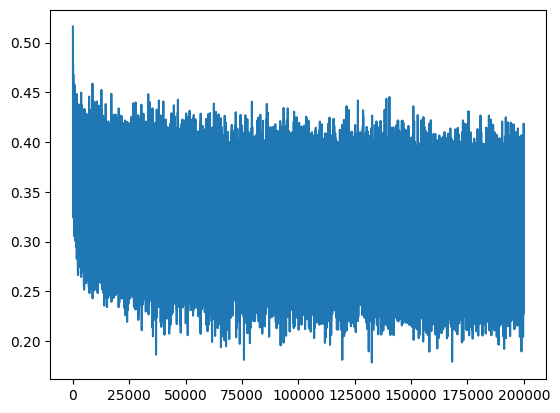

In [396]:
plt.plot(list(map(lambda x: x.log10().item(), losstrn)))

### Print the loss on the training, validation and testing datasets

In [397]:
print(f"Training Loss: {getloss(Xtrn, Ytrn).item()}")
print(f"Validation Loss: {getloss(Xdev, Ydev).item()}")
print(f"Testing Loss: {getloss(Xtst, Ytst).item()}")

Training Loss: 2.036288261413574
Validation Loss: 2.0913302898406982
Testing Loss: 2.11007022857666


(array([1299.,  371.,  307.,  292.,  189.,  220.,  216.,  212.,  158.,
         174.,  112.,  127.,   93.,  103.,   96.,   87.,  118.,  106.,
          81.,   88.,   57.,   81.,   71.,   90.,   96.,   87.,   69.,
          67.,   85.,   83.,   68.,  103.,   99.,  123.,  122.,  107.,
         122.,  159.,  120.,  146.,  166.,  184.,  114.,  173.,  222.,
         258.,  292.,  290.,  413., 1084.]),
 array([-9.99998868e-01, -9.59998950e-01, -9.19999032e-01, -8.79999114e-01,
        -8.39999197e-01, -7.99999279e-01, -7.59999361e-01, -7.19999443e-01,
        -6.79999526e-01, -6.39999608e-01, -5.99999690e-01, -5.59999772e-01,
        -5.19999855e-01, -4.79999937e-01, -4.40000019e-01, -4.00000101e-01,
        -3.60000184e-01, -3.20000266e-01, -2.80000348e-01, -2.40000430e-01,
        -2.00000513e-01, -1.60000595e-01, -1.20000677e-01, -8.00007594e-02,
        -4.00008416e-02, -9.23871994e-07,  3.99989939e-02,  7.99989116e-02,
         1.19998829e-01,  1.59998747e-01,  1.99998665e-01,  2.399985

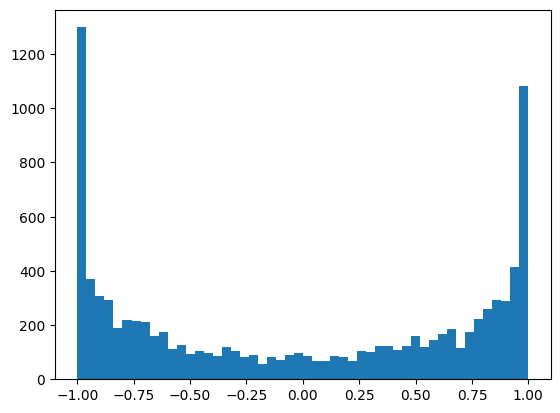

In [398]:
plt.hist(h.view(-1).tolist(), bins=50)

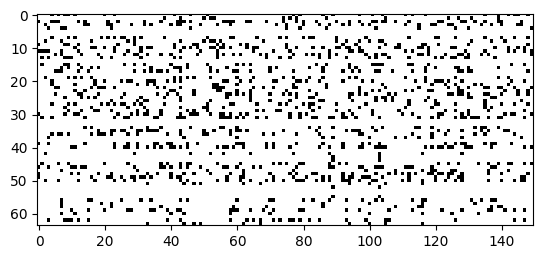

In [399]:
plt.imshow(h.abs() < 0.99, cmap='gray', interpolation='nearest')

(array([  1.,   0.,   0.,   0.,   2.,   0.,   2.,   9.,   6.,  11.,  22.,
         28.,  30.,  50.,  72.,  86., 100., 167., 198., 254., 293., 454.,
        477., 521., 584., 579., 504., 567., 603., 558., 507., 538., 510.,
        361., 399., 256., 233., 172., 110.,  99.,  87.,  45.,  33.,  26.,
         20.,   9.,   6.,   5.,   2.,   4.]),
 array([-8.49072742, -8.18146067, -7.87219391, -7.56292715, -7.25366039,
        -6.94439363, -6.63512688, -6.32586012, -6.01659336, -5.7073266 ,
        -5.39805984, -5.08879309, -4.77952633, -4.47025957, -4.16099281,
        -3.85172606, -3.5424593 , -3.23319254, -2.92392578, -2.61465902,
        -2.30539227, -1.99612551, -1.68685875, -1.37759199, -1.06832523,
        -0.75905848, -0.44979172, -0.14052496,  0.1687418 ,  0.47800856,
         0.78727531,  1.09654207,  1.40580883,  1.71507559,  2.02434235,
         2.3336091 ,  2.64287586,  2.95214262,  3.26140938,  3.57067614,
         3.87994289,  4.18920965,  4.49847641,  4.80774317,  5.11700993,
 

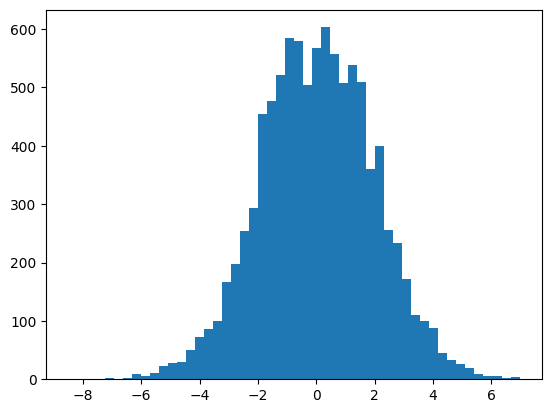

In [400]:
plt.hist((emb.view((-1, block_size*dims)) @ W1 + b1).view(-1).tolist(), bins=50)

### Function to generate a new word based using current model

In [401]:
def generate():
    op = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # print(probs)
        nxti = torch.multinomial(probs, num_samples=1).item()
        if nxti == 0: return ''.join([itoc[x] for x in op])
        context = context[1:] + [nxti]
        op.append(nxti)

### Generate and print 20 samples

In [402]:
for _ in range(20): print(generate())

gaz
siscolly
kamlarsh
koldgerthonsommarcy
pren
khirly
clmishakinmc
gmancaanylvahnay
handrughann
bapcodellastynn
jjonnchlynn
kamrcomnsi
zaydestmyannanednestanyscharkelannon
zamnaqu
thanfimzavingchlamyylex
skyry
graczrahazakingaivegshyle
strijocmanyanzakyustorr
zah
cjarmonnon
